In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, validation_curve, StratifiedShuffleSplit, StratifiedKFold
from sklearn import preprocessing
from imblearn import over_sampling
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score

In [70]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Load the dataset file
creditcard=pd.read_csv('creditcard.csv', index_col=None)

creditcard.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


Exploratory Data Analysis

In [4]:
# Evaluate number of columns and rows in given dataset
Number_of_row = creditcard.shape[0]
Number_of_column = creditcard.shape[1]

print('Number of rows in creditcard file     :', Number_of_row)
print('Number of columns in creditcard file  :', Number_of_column)

Number of rows in creditcard file     : 284807
Number of columns in creditcard file  : 31


In [5]:
# Time column 
creditcard['Time'] =creditcard['Time']/3600 # 1 hour =3600 seconds

print(creditcard['Time'].describe()) # Data is 48 hours

count    284807.000000
mean         26.337183
std          13.191152
min           0.000000
25%          15.055972
50%          23.525556
75%          38.700139
max          47.997778
Name: Time, dtype: float64


In [6]:
# Assignment of classes 1 and 0 for visualization 
def replace_data_to_binary(x,y):
    creditcard.Class.replace(x,y, inplace=True)
    
replace_data_to_binary(0, 'Non Fraudulent')
replace_data_to_binary(1, 'Fraudulent')

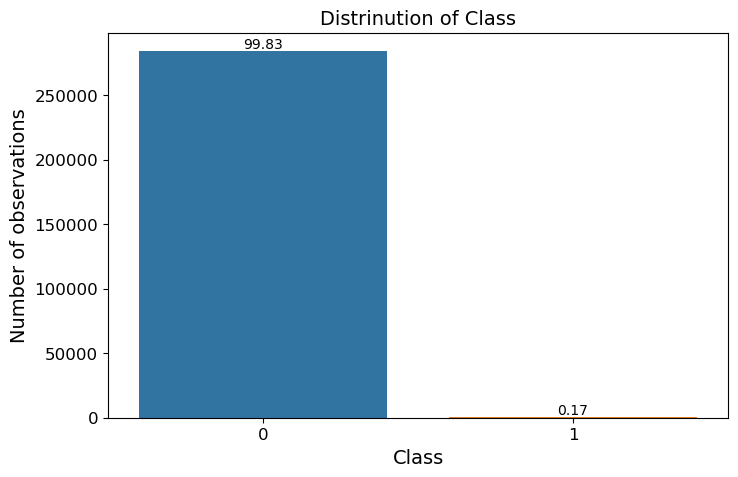

In [98]:
# Class distribution
fig = plt.figure(figsize=(8,5))
ax = sns.countplot(x="Class",  data=creditcard)
ax.grid(False)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of observations', fontsize=14)
plt.title('Distrinution of Class', fontsize =14)

total = float(len(creditcard)) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(100*height/total), 
            ha="center",va='bottom')

plt.tick_params(labelsize=12)
plt.show()

In [8]:
# Class Imbalance
total_count = creditcard['Class'].value_counts()
imbalance= (total_count['Fraudulent']/creditcard['Class'].count()*100)/(total_count['Non Fraudulent']/creditcard['Class'].count()*100)*100
print('Imbalance Percentage : {:.3f}%'.format(imbalance))

Imbalance Percentage : 0.173%


In [9]:
# Class: Amount
print("Amount details of Fraudulent transaction :")
print(creditcard[creditcard["Class"] == "Fraudulent"].Amount.describe())
print('\n')
print("Amount details of non-fraudulent transaction :")
print(creditcard[creditcard["Class"] == "Non Fraudulent"].Amount.describe())

Amount details of Fraudulent transaction :
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


Amount details of non-fraudulent transaction :
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


Time - amount of transactions between fraudulent and non-fraudulent


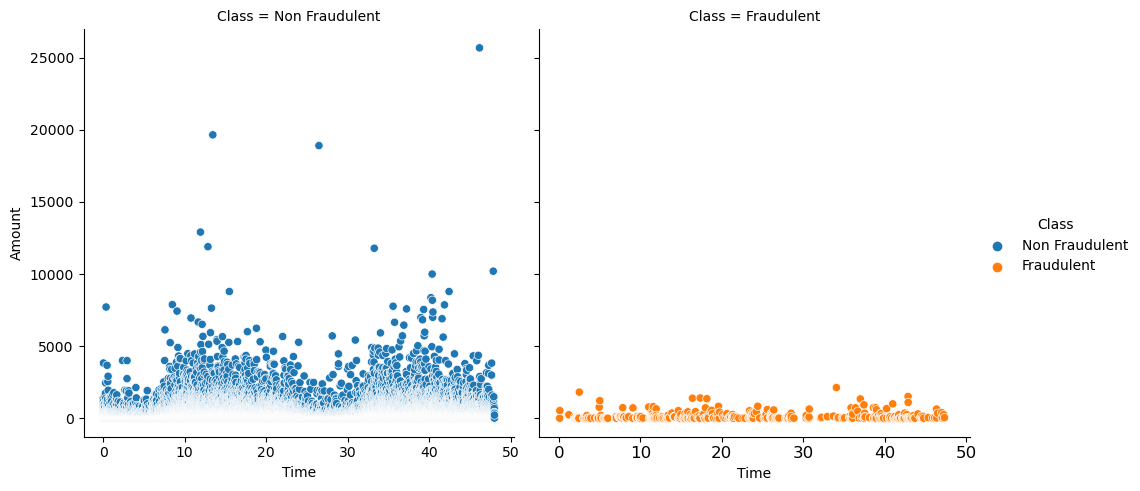

In [10]:
# Class: Time - Amount
print("Time - amount of transactions between fraudulent and non-fraudulent")
ax=sns.relplot(x="Time", y="Amount",
                 col="Class", hue="Class",
                 kind="scatter", data=creditcard)
plt.tick_params(labelsize=12)
plt.show()

In [11]:
# Assign back to class 1 and 0 for analysis  
replace_data_to_binary('Non Fraudulent', 0)
replace_data_to_binary ('Fraudulent', 1)

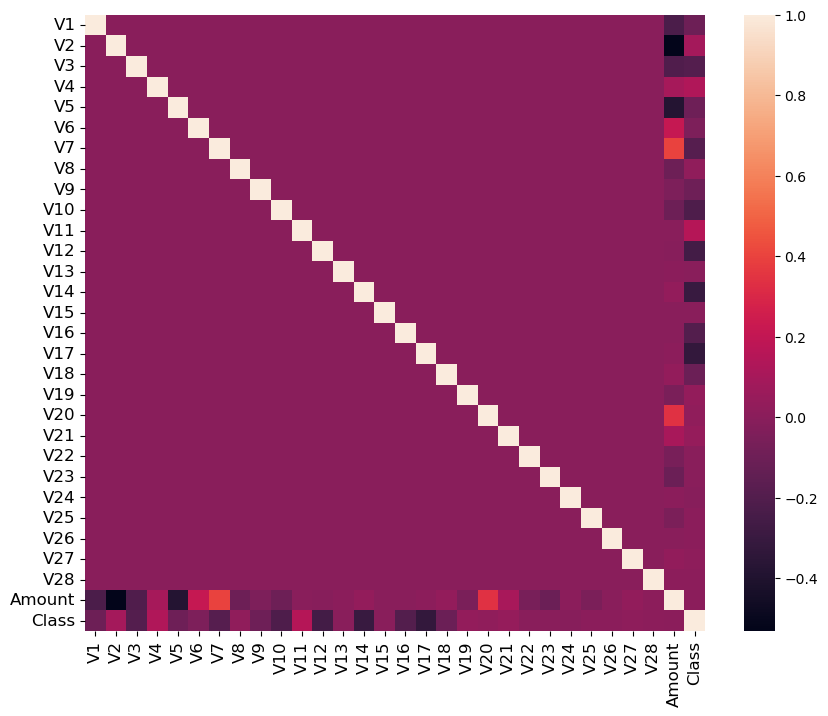

In [96]:
# Evaluate the correlation between different parameters
creditcard_corr=creditcard.corr()
fig = plt.figure(figsize=(10,8))
ax=sns.heatmap(creditcard_corr)
plt.tick_params(labelsize=12)
plt.show()

# Few insights on the visualization above reveal the following:
# 1. V7 and V20 are positively correlated with the amount.
# 2. V2 and V5 are negatively correlated with the amount.

In [13]:
Non_Fraudulent= creditcard[creditcard["Class"] == 0]

# Non_Fraudulent: Mean, Variance, Skewness, and Kurtosis
a = Non_Fraudulent.mean(axis = 0, skipna = True)
b = Non_Fraudulent.var(axis = 0, skipna = True)
c = Non_Fraudulent.skew(axis = 0, skipna = True)
d = Non_Fraudulent.kurtosis(axis = 0, skipna = True)

data_Non_Fraudulent = pd.concat([a, b, c, d] ,axis = 1)
data_Non_Fraudulent.columns = ["Mean", "Var", "Skewness", "kurtosis"]
data_Non_Fraudulent = data_Non_Fraudulent.reset_index().rename(index=str, columns={"index": "Variables"})
print(data_Non_Fraudulent)

   Variables       Mean           Var   Skewness    kurtosis
0       Time  26.343945    173.976216  -0.036015   -1.293597
1         V1   0.008258      3.724182  -3.130188   31.065568
2         V2  -0.006271      2.676974  -4.887166   98.406211
3         V3   0.012171      2.129933  -1.453676   14.545345
4         V4  -0.007860      1.958134   0.581137    2.095716
5         V5   0.005453      1.841318  -2.213903  217.852170
6         V6   0.002419      1.768669   1.842604   42.987534
7         V7   0.009637      1.389598   4.747800  452.920870
8         V8  -0.000987      1.348579  -8.395492  209.772662
9         V9   0.004467      1.186731   0.665635    3.196847
10       V10   0.009824      1.090361   2.422278   21.961970
11       V11  -0.006576      1.006233   0.145537    0.035641
12       V12   0.010832      0.894801  -1.256301    5.300894
13       V13   0.000189      0.990157   0.065582    0.196578
14       V14   0.012064      0.804621  -0.703857    7.719480
15       V15   0.000161 

In [14]:
Fraudulent= creditcard[creditcard["Class"] == 1]

# Fraudulent: Mean, Variance, Skewness, and Kurtosis
a = Fraudulent.mean(axis = 0, skipna = True)
b = Fraudulent.var(axis = 0, skipna = True)
c = Fraudulent.skew(axis = 0, skipna = True)
d = Fraudulent.kurtosis(axis = 0, skipna = True)

data_Fraudulent = pd.concat([a, b, c, d] ,axis = 1)
data_Fraudulent.columns = ["Mean", "Var", "Skewness", "kurtosis"]
data_Fraudulent = data_Fraudulent.reset_index().rename(index=str, columns={"index": "Variables"})
print(data_Fraudulent)

   Variables        Mean           Var  Skewness   kurtosis
0       Time   22.429669    176.560352  0.251173  -1.154832
1         V1   -4.771948     46.018406 -1.797617   2.879609
2         V2    3.623778     18.414532  1.226561   2.597563
3         V3   -7.033281     50.565429 -1.514985   1.781004
4         V4    4.542029      8.255955  0.496746  -0.197493
5         V5   -3.151225     28.863413 -1.361139   1.728831
6         V6   -1.397737      3.452623  0.867734   2.876068
7         V7   -5.568731     51.937575 -1.827599   4.245361
8         V8    0.570636     46.210501 -2.830022  16.764743
9         V9   -2.581123      6.254479 -0.975075   1.494887
10       V10   -5.676883     23.983949 -1.152719   1.450166
11       V11    3.800173      7.174922  0.499090   0.207397
12       V12   -6.259393     21.663984 -0.666830  -0.196194
13       V13   -0.109334      1.219961 -0.025996  -0.434002
14       V14   -6.971723     18.309327 -0.251554  -0.282136
15       V15   -0.092929      1.102322 -

Data Processing

In [15]:
creditcard = creditcard.drop(['Time'],axis=1) # drop the time column
creditcard['Amount'] = StandardScaler().fit_transform(creditcard['Amount'].values.reshape(-1,1)) # standardize amount column

In [16]:
# Create X and y
X = creditcard.drop('Class',axis=1)
y = creditcard['Class']

# Split the data into train and test with 70-30 division 
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, train_size=0.7,  random_state=0)

In [17]:
# Adopt power transformation to deal with skewness by 'yeo-johnson' method
creditcard_pt= preprocessing.PowerTransformer(method='yeo-johnson', copy=True)

creditcard_pt.fit(X_train)
X_train_pt = creditcard_pt.transform(X_train)
X_test_pt = creditcard_pt.transform(X_test)
y_train_pt = y_train

In [18]:
# Balance data Method used ADASYN oversampling on the minority class
X_ada, y_ada = over_sampling.ADASYN(sampling_strategy='minority', random_state=42).fit_resample(X_train_pt, y_train_pt)
print('Resampled dataset shape %s' % Counter(y_ada))

# Evaluate whether the dataset is balanced at what percentage level

total_count = y_ada.value_counts()
imbalance= (total_count[1]/y_ada.count()*100)/(total_count[0]/y_ada.count()*100)*100
print('Balance Percentage after ADASYN : {:.2f}%'.format(imbalance))

Resampled dataset shape Counter({0: 199019, 1: 198983})
Balance Percentage after ADASYN : 99.98%


In [19]:
# Rename X_ada and y_ada
X_train = X_ada
y_train = y_ada

Modelling

1. Logistic Regression

In [20]:
lgreg = LogisticRegression(penalty='l1', solver='liblinear',random_state=0, max_iter=1000).fit(X_train, y_train)
param_C_range = [1e-9, 1e-5, 1e-3, 1e-2, 1e-1, 1.0,10,100]

stratified_cv = StratifiedShuffleSplit(n_splits = 10, random_state = 0)
train_scores, val_scores = validation_curve(estimator=lgreg, 
                                            X=X_train, 
                                            y=y_train, 
                                            param_name='C', 
                                            param_range=param_C_range,
                                            cv=stratified_cv,
                                            n_jobs=-1,
                                            scoring='f1')

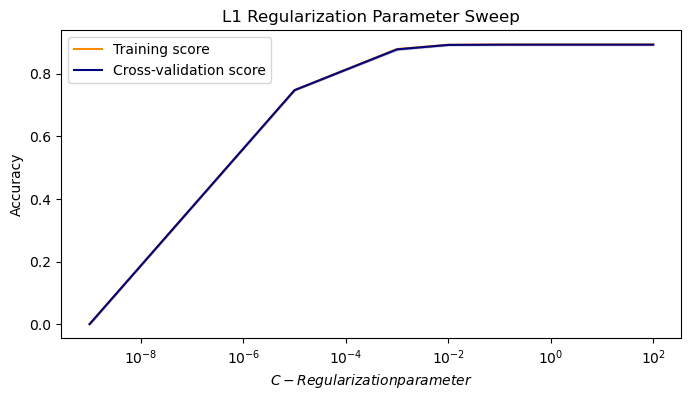

In [93]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,4))
plt.title('L1 Regularization Parameter Sweep')
plt.xlabel("$C-Regularization parameter$")
plt.ylabel("Accuracy")

plt.semilogx(param_C_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(param_C_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
plt.semilogx(param_C_range, val_scores_mean, label="Cross-validation score", color="navy")
plt.fill_between(param_C_range, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2, color="navy")
plt.legend(loc="best")

In [33]:
# C = 0.01 selected from the graph above
lgreg = LogisticRegression(penalty='l1', C=0.01,solver='liblinear',random_state=0, max_iter=1000).fit(X_train, y_train)
y_pred = lgreg.predict(X_test)
y_prob = lgreg.predict_proba(X_test)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [48]:
# Evaluation
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
logloss = metrics.log_loss(y_test, y_pred)
prc_auc = metrics.average_precision_score(y_test, y_prob[:,1], average='weighted')

print('Test accuracy: %.4f' % (accuracy))
print('\nTest Precision: %.4f' % (precision))
print('\nTest Recall: %.4f' % (recall))
print('\nTest LogLoss: %.4f' % (logloss))
print('\nTest AUPRC: %.4f' % (prc_auc))

Test accuracy: 0.8579

Test Precision: 0.0116

Test Recall: 0.9660

Test LogLoss: 5.1225

Test AUPRC: 0.7244


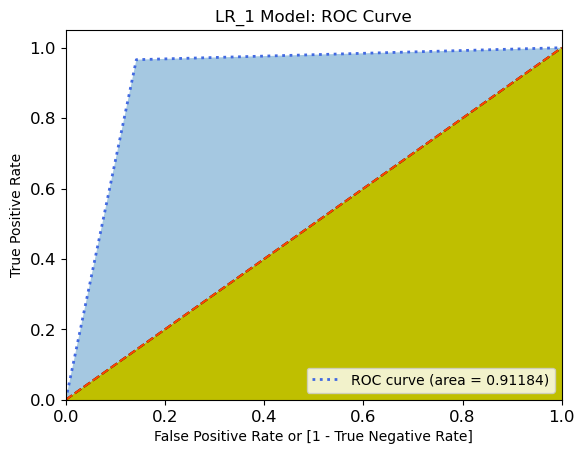

In [77]:
# ROC Curve
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
auc_score = roc_auc_score(y_test,y_pred)
plt.plot(fpr, tpr, linestyle = "dotted", color = "royalblue",linewidth = 2, label='ROC curve (area = %0.5f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('LR_1 Model: ROC Curve', fontsize =12)
plt.legend(loc="lower right")
plt.tick_params(labelsize=12)
plt.plot([0,1],[0,1],linestyle = "dashed",
             color = "orangered",linewidth = 1.5)
plt.fill_between(fpr,tpr,alpha = .4)
plt.fill_between([0,1],[0,1],color = "y")

[Text(0, 0.5, 'Not Fraudulent'), Text(0, 1.5, 'Fraudulent')]

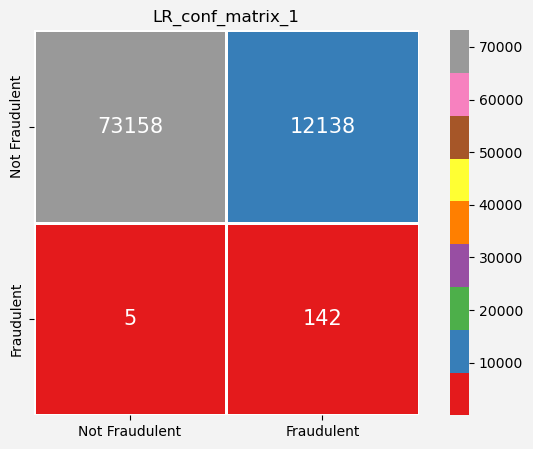

In [92]:
# Confusion Matrix

classes = ['Not Fraudulent', 'Fraudulent']
LR_conf_matrix_1 = confusion_matrix(y_test,y_pred)
fig = plt.figure(figsize=(8,5))
fig.set_facecolor("#F3F3F3")
ax= sns.heatmap(LR_conf_matrix_1,annot=True, annot_kws={"fontsize":15}, fmt = "",square = True,
                xticklabels=classes,
                yticklabels=classes,
                linewidths = 2,linecolor = "w",cmap = "Set1")
plt.title("LR_conf_matrix_1", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, horizontalalignment='right')

2. XGBoost

In [40]:
# Perform cross-validation using stratified k fold method on the X_train & y_train 
X_train_xg = X_train_pt
y_train_xg = y_train_pt

skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

cv_score_mean=0
for n_estimators in [100,50]:
    for learning_rate in [0.2,0.6]:
        for subsample in [0.3, 0.6, 0.9]:
            print("n_estimators=",n_estimators,"learning_rate=",learning_rate, "subsample=",subsample)
            for train_index, test_index in skf.split(X_train_xg, y_train_xg):
                X_train_cv, X_test_cv = X_train_xg[train_index], X_train_xg[test_index]
                y_train_cv, y_test_cv = y_train_xg.iloc[train_index], y_train_xg.iloc[test_index]

                ros = over_sampling.ADASYN(sampling_strategy='minority', random_state=42)
                X_ros_cv,y_ros_cv = ros.fit_resample(X_train_cv,y_train_cv)

                xgboost_classifier= XGBClassifier(n_estimators=n_estimators,
                                                learning_rate=learning_rate,
                                                subsample=subsample, n_jobs=-1,
                                                eval_metric='logloss',
                                                use_label_encoder=False)
                xgboost_classifier.fit(X_ros_cv, y_ros_cv)

                y_test_pred= xgboost_classifier.predict_proba(X_test_cv)
                cv_score= metrics.roc_auc_score(y_true=y_test_cv,y_score=y_test_pred[:,1])
                cv_score_mean=cv_score_mean+cv_score
            print("Cross Val ROC-AUC Score=", cv_score_mean/3)

n_estimators= 100 learning_rate= 0.2 subsample= 0.3
Cross Val ROC-AUC Score= 0.9776865170042074
n_estimators= 100 learning_rate= 0.2 subsample= 0.6
Cross Val ROC-AUC Score= 1.9549011119673774
n_estimators= 100 learning_rate= 0.2 subsample= 0.9
Cross Val ROC-AUC Score= 2.9316318263307823
n_estimators= 100 learning_rate= 0.6 subsample= 0.3
Cross Val ROC-AUC Score= 3.9034916100786
n_estimators= 100 learning_rate= 0.6 subsample= 0.6
Cross Val ROC-AUC Score= 4.881800643794561
n_estimators= 100 learning_rate= 0.6 subsample= 0.9
Cross Val ROC-AUC Score= 5.856334616961381
n_estimators= 50 learning_rate= 0.2 subsample= 0.3
Cross Val ROC-AUC Score= 6.832843262849475
n_estimators= 50 learning_rate= 0.2 subsample= 0.6
Cross Val ROC-AUC Score= 7.8103926396586365
n_estimators= 50 learning_rate= 0.2 subsample= 0.9
Cross Val ROC-AUC Score= 8.789063833328443
n_estimators= 50 learning_rate= 0.6 subsample= 0.3
Cross Val ROC-AUC Score= 9.759114665917602
n_estimators= 50 learning_rate= 0.6 subsample= 0.6
C

In [41]:
# Select tree number
tree_range = range(2, 100, 5)
score1=[]
score2=[]
for tree in tree_range:
    xgb=XGBClassifier(n_estimators=tree,
                      eval_metric='mlogloss',
                      use_label_encoder=False)
    xgb.fit(X_train,y_train)
    score1.append(xgb.score(X_train,y_train))
    score2.append(xgb.score(X_test,y_test))

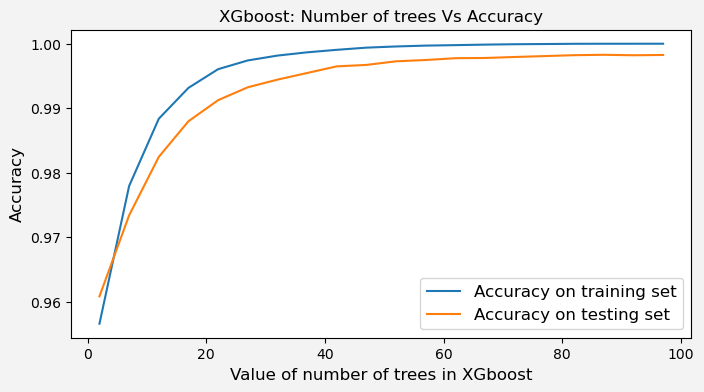

In [43]:
fig = plt.figure(figsize=(8,4))
fig.set_facecolor("#F3F3F3")
plt.plot(tree_range,score1,label= 'Accuracy on training set')
plt.plot(tree_range,score2,label= 'Accuracy on testing set')
plt.title('XGboost: Number of trees Vs Accuracy', fontsize =12)
plt.xlabel('Value of number of trees in XGboost', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc = "best",
               prop = {"size" : 12})
plt.show()

In [47]:
# Use the optimized parameters
xgb=XGBClassifier(n_estimators=90, learning_rate=0.6, subsample=0.9, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train,y_train)
print('Accuracy of XGB n=100 on the testing dataset is :{:.4f}'.format(xgb.score(X_test,y_test)))

Accuracy of XGB n=100 on the testing dataset is :0.9984


3. Various models

In [51]:
model_summary = []
ML_models = {}

model_index = ['LR','RF','NN', 'GRB', 'DT', 'XGB']
model_sklearn = [LogisticRegression(penalty = 'l2', C = 1, random_state=0),
                 RandomForestClassifier(n_jobs=3, min_samples_split = 20, min_samples_leaf = 5, random_state=0),
                 MLPClassifier([100]*5,early_stopping=True,learning_rate='adaptive',random_state=0),
                 GradientBoostingClassifier(n_estimators = 50, max_depth = 2, random_state = 0),
                 DecisionTreeClassifier(random_state=42, max_depth=6),
                 XGBClassifier(n_estimators=100,learning_rate=0.2,subsample=0.3, n_jobs=-1,
                              eval_metric='mlogloss',use_label_encoder=False)]

for name,model in zip(model_index,model_sklearn):
    ML_models[name] = model.fit(X_train,y_train)
    preds = model.predict(X_test)
    model_summary.append([name,f1_score(y_test,preds,average='weighted'),accuracy_score(y_test,preds),
                          roc_auc_score(y_test,model.predict_proba(X_test)[:,1]), precision_score(y_test,preds, average='weighted'),
                         recall_score(y_test,preds, average='weighted')])
   
    
print(ML_models)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without f

{'LR': LogisticRegression(C=1, random_state=0), 'RF': RandomForestClassifier(min_samples_leaf=5, min_samples_split=20, n_jobs=3,
                       random_state=0), 'NN': MLPClassifier(early_stopping=True, hidden_layer_sizes=[100, 100, 100, 100, 100],
              learning_rate='adaptive', random_state=0), 'GRB': GradientBoostingClassifier(max_depth=2, n_estimators=50, random_state=0), 'DT': DecisionTreeClassifier(max_depth=6, random_state=42), 'XGB': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,

Model evaluation

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


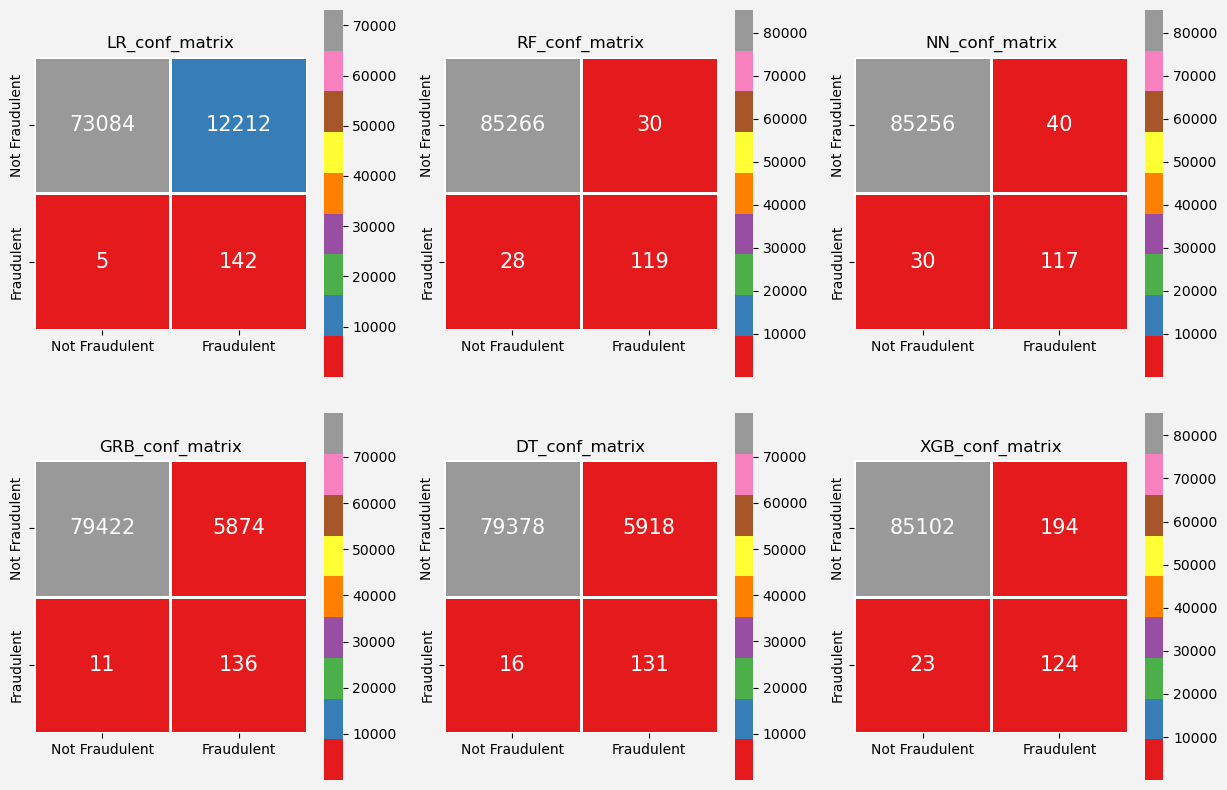

In [65]:
# Confusion matrix for LR, RF, NN, GRB, DT, XGB models
LR_conf_matrix = confusion_matrix(y_test,ML_models['LR'].predict(X_test))
RF_conf_matrix = confusion_matrix(y_test,ML_models['RF'].predict(X_test))
NN_conf_matrix = confusion_matrix(y_test,ML_models['NN'].predict(X_test))
GRB_conf_matrix = confusion_matrix(y_test,ML_models['GRB'].predict(X_test))
DT_conf_matrix = confusion_matrix(y_test,ML_models['DT'].predict(X_test))
XGB_conf_matrix = confusion_matrix(y_test,ML_models['XGB'].predict(X_test))

def plot_confusion_matrix(conf_matrix, model_name, index):
    plt.subplot(2,3, index)
    ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"fontsize": 15}, fmt="", square=True,
                     xticklabels=["Not Fraudulent", "Fraudulent"],
                     yticklabels=["Not Fraudulent", "Fraudulent"],
                     linewidths=2, linecolor="w", cmap="Set1", cbar_kws={'shrink': 1})
    plt.title(f"{model_name}_conf_matrix", fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90, horizontalalignment='right')

fig = plt.figure(figsize=(15, 10))
fig.set_facecolor("#F3F3F3")

plot_confusion_matrix(LR_conf_matrix, "LR", 1)
plot_confusion_matrix(RF_conf_matrix, "RF", 2)
plot_confusion_matrix(NN_conf_matrix, "NN", 3)
plot_confusion_matrix(GRB_conf_matrix, "GRB", 4)
plot_confusion_matrix(DT_conf_matrix, "DT", 5)
plot_confusion_matrix(XGB_conf_matrix, "XGB", 6)

plt.subplots_adjust(hspace=0.1, wspace=0.2)
plt.show()

In [76]:
# Calculate speficity, sensitivity, FPR, positive predictive value and Negative predictive value
def evaluate_model(model, X_test, y_test, model_name):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    print(f"            {model_name} Model:")
    print('Sensitivity               :  {:.4f}'.format(tp / (tp + fn)))
    print('Specificity               :  {:.4f}'.format(tn / (tn + fp)))
    print('False postive rate        :  {:.4f}'.format(fp / (tn + fp)))
    print('Positive predictive value :  {:.4f}'.format(tp / (tp + fp)))
    print('Negative predictive value :  {:.4f}'.format(tn / (tn + fn)))
    print('---------------------------------------------------')

# 将函数应用于每个模型
for model_name, model in ML_models.items():
    evaluate_model(model, X_test, y_test, model_name)

            LR Model:
Sensitivity               :  0.9660
Specificity               :  0.8568
False postive rate        :  0.1432
Positive predictive value :  0.0115
Negative predictive value :  0.9999
---------------------------------------------------
            RF Model:
Sensitivity               :  0.8095
Specificity               :  0.9996
False postive rate        :  0.0004
Positive predictive value :  0.7987
Negative predictive value :  0.9997
---------------------------------------------------
            NN Model:
Sensitivity               :  0.7959
Specificity               :  0.9995
False postive rate        :  0.0005
Positive predictive value :  0.7452
Negative predictive value :  0.9996
---------------------------------------------------
            GRB Model:
Sensitivity               :  0.9252
Specificity               :  0.9311
False postive rate        :  0.0689
Positive predictive value :  0.0226
Negative predictive value :  0.9999
-----------------------------------

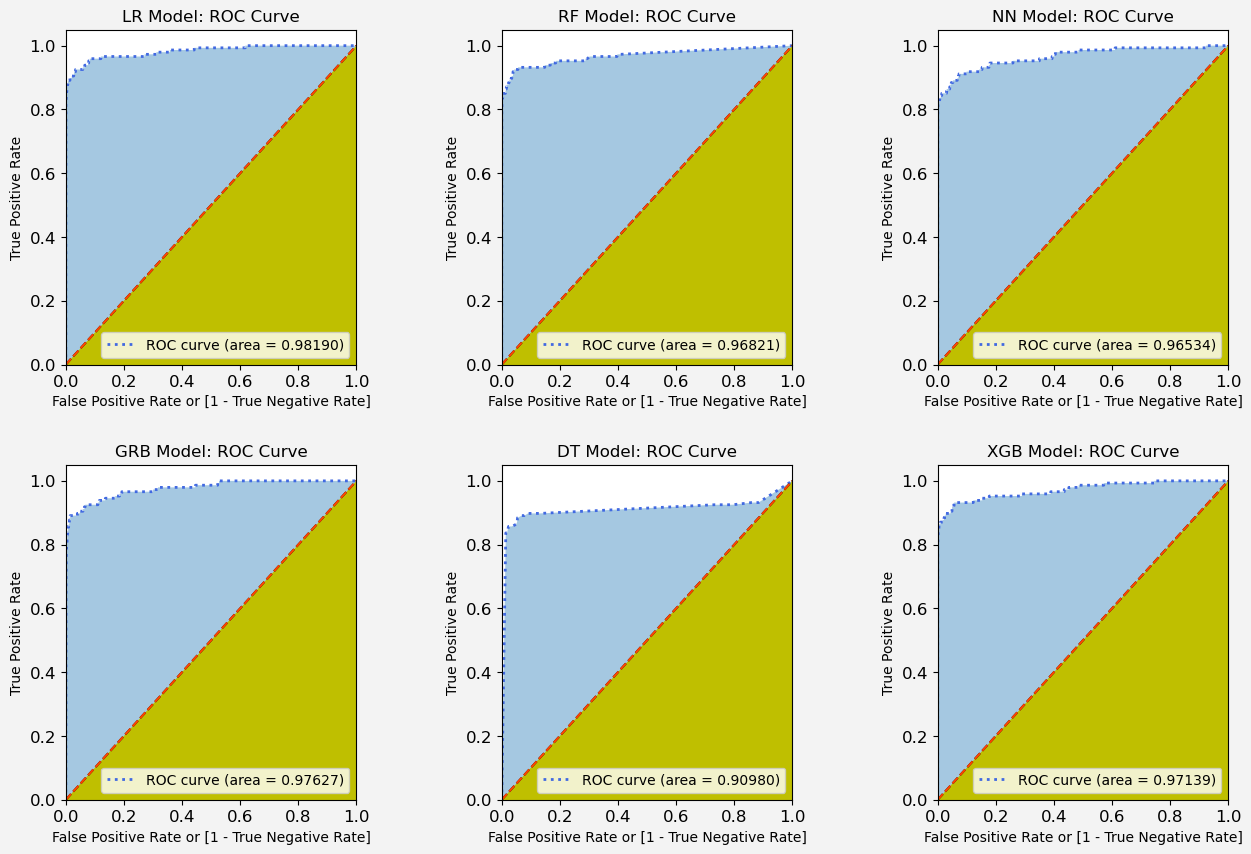

In [84]:
# ROC - Curves for all the models
fig = plt.figure(figsize=(15,10))
fig.set_facecolor("#F3F3F3")

def plot_roc_curve(model_name, y_test, index):
    plt.subplot(2,3, index)
    fpr,tpr,thresholds = roc_curve(y_test,ML_models[model_name].predict_proba(X_test)[:,1])
    auc_score = roc_auc_score(y_test,ML_models[model_name].predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, linestyle="dotted", color="royalblue", linewidth=2, label='ROC curve (area = %0.5f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Model: ROC Curve', fontsize=12)
    plt.legend(loc="lower right")
    plt.tick_params(labelsize=12)
    plt.plot([0, 1], [0, 1], linestyle="dashed", color="orangered", linewidth=1.5)
    plt.fill_between(fpr, tpr, alpha=.4)
    plt.fill_between([0, 1], [0, 1], color="y")

plot_roc_curve('LR', y_test, 1)
plot_roc_curve('RF', y_test, 2)
plot_roc_curve('NN', y_test, 3)
plot_roc_curve('GRB', y_test, 4)
plot_roc_curve('DT', y_test, 5)
plot_roc_curve('XGB', y_test, 6)

plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()

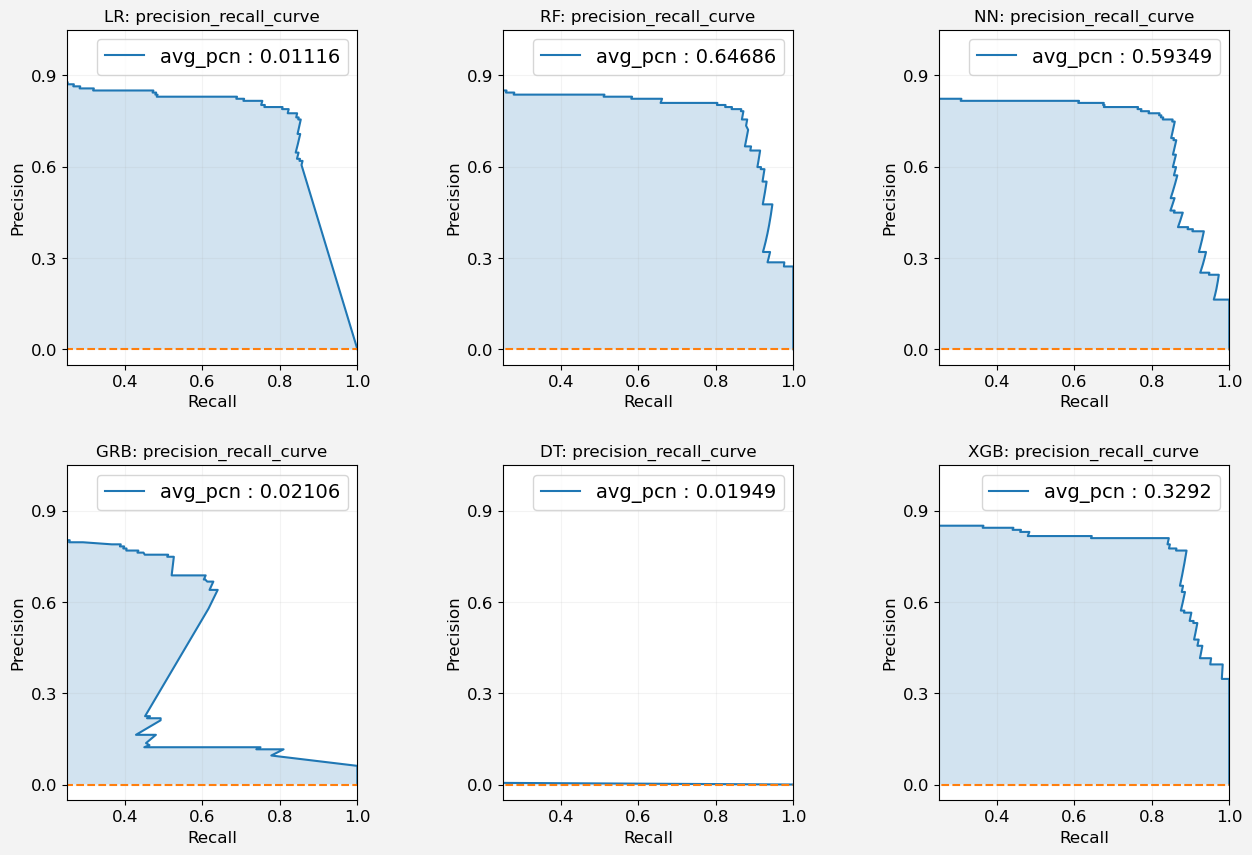

In [91]:
# Precision recall curves for all the models

fig = plt.figure(figsize=(15,10))
fig.set_facecolor("#F3F3F3")

def plot_pr_curve(model_name, y_test, index):
    plt.subplot(2,3, index)
    recall,precision,thresholds = precision_recall_curve(y_test,ML_models[model_name].predict_proba(X_test)[:,1])
    plt.plot(recall,precision,linewidth = 1.5,
                label = ("avg_pcn : " + 
                        str(np.around(average_precision_score(y_test,ML_models[model_name].predict(X_test)),5))))
    plt.plot([0,1],[0,0],linestyle = "dashed")
    plt.fill_between(recall,precision,alpha = .2)
    plt.legend(loc = 'best',
                prop = {"size" : 14})
    plt.grid(True,alpha = .15)
    plt.title( f'{model_name}: precision_recall_curve', fontsize =12)
    plt.xlabel("Recall",fontsize =12)
    plt.ylabel("Precision",fontsize =12)
    plt.xlim([0.25,1])
    plt.yticks(np.arange(0,1,.3))
    plt.tick_params(labelsize=12)

plot_pr_curve('LR', y_test, 1)
plot_pr_curve('RF', y_test, 2)
plot_pr_curve('NN', y_test, 3)
plot_pr_curve('GRB', y_test, 4)
plot_pr_curve('DT', y_test, 5)
plot_pr_curve('XGB', y_test, 6)

plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()

**CONCLUSION**

1. Total 5 models were created to detect credit card fraudulent transactions, including Logistics Regression, Random Forest, Neutral Network, Gradient Boosting, Decision Tree and XGBoost.

2. All the models were evaluated base on different metrics, including Accuracy, Recall, and Precision. The model should strike the right balance between precision and recall, as identifying the fraud precisely is as important as reducing the misidentification of transactions. And the area under the ROC curve plays an important role in the selection of model, as a measure of the classifier's ability to distinguish between positive and negative samples

3. Model recommendations: 
   (1) Based on the Area under the ROC curve, the Logistic Regression model with L2 penalty was considered to be the best with AUC of 0.9862. The Recall of the LR model is 0.9387, and the Precision is 0.9383, which are both quite good values;
   (2) The GRB model also had good peformance with the AUC value of 0.977. The Recall for the LR model is 0.9183, and the Precision is 0.9183 with an accuracy of 0.918, which is very well-balanced for the scenario.